**Model Synopsis**:  
This model predicts whether a given currency will break out of it's  
current low. It is designed to aid in trend reversals and help filter  
false breakouts. 

**Model Structure**:
As currently constructed, the model contains an input layer with  
the number of neurons equal to the number of columns in the dataset.  
It then contains four hidden layers with ReLU activation functions  
and an output layer with a sigmoid activation function.

**Model Accuracy**:
The model currently has a train accuracy of 0.90 and a test accuracy  
of 0.86.

In [79]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow import keras
import sklearn as sk

# keras functions to use
from keras.models import Sequential
from keras.layers import Dense, Activation

import warnings  
warnings.filterwarnings('ignore')

In [80]:
data = pd.read_csv('breakout.csv') # read csv file of trades
data.head()

,pair,frame,rg,h,l,c1,c2,c3,supp,o_s,p_s,obv1,obv2,obv3,rsi1,rsi2,rsi3,natr,cyc,result
0,AUD_USD,H4,43,0.72335,0.71724,0.71832,0.72162,0.72284,0.71918,-0.000094,0.000436,0.760388,0.912523,1.009889,32.233819,38.364744,41.044732,0.416365,2.242858,0.0
1,AUD_USD,H4,44,0.72335,0.71724,0.71832,0.72162,0.72284,0.71918,-0.000061,0.001953,0.760388,0.912523,1.009889,31.993635,38.123138,40.806982,0.416365,2.242858,0.0
2,AUD_USD,H4,45,0.72335,0.71724,0.71832,0.72162,0.72284,0.71832,-0.000029,0.003516,0.760388,0.912523,1.009889,32.010803,38.152621,40.842773,0.416365,2.242858,0.0
3,AUD_USD,H4,46,0.72335,0.71724,0.71832,0.72162,0.72284,0.71832,-0.000003,0.004581,0.760388,0.912523,1.009889,31.490587,37.543560,40.195911,0.416365,2.242858,0.0
4,AUD_USD,H4,47,0.72335,0.71724,0.71832,0.72162,0.72284,0.71832,0.000019,0.005376,0.760388,0.912523,1.009889,31.150450,37.181479,39.828662,0.416365,2.242858,0.0


In [81]:
print("len of result:", len(data['result']))

len of result: 8274


In [82]:
# drop string columns
data.drop(data.columns[[0, 1]], axis=1, inplace=True) # drop date
    
# convert to float
for col in data:
    data[col] = pd.to_numeric(data[col])
    
# delete rows with nans
data = data.dropna()

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8144 entries, 0 to 8149
Data columns (total 18 columns):
rg        8144 non-null int64
h         8144 non-null float64
l         8144 non-null float64
c1        8144 non-null float64
c2        8144 non-null float64
c3        8144 non-null float64
supp      8144 non-null float64
o_s       8144 non-null float64
p_s       8144 non-null float64
obv1      8144 non-null float64
obv2      8144 non-null float64
obv3      8144 non-null float64
rsi1      8144 non-null float64
rsi2      8144 non-null float64
rsi3      8144 non-null float64
natr      8144 non-null float64
cyc       8144 non-null float64
result    8144 non-null float64
dtypes: float64(17), int64(1)
memory usage: 1.2 MB


In [84]:
pos = (list(np.where(data['result'] == 1)[0]))
neg = (list(np.where(data['result'] == 0)[0]))

print("breakouts:", len(pos), " | ", "false breakouts:", len(neg))

breakouts: 1879  |  false breakouts: 6265


In [85]:
# try to balance the results
pos_count = len(pos)
neg_count = len(neg) * 0.95

# we want to delete randomly
import random

while neg_count > pos_count:
    
    rand = random.randint(1,len(neg)-1)
    row = neg[rand]
    
    if row >= len(data['result']):
        continue
    
    data = data.drop(data.index[row])
    neg_count += -1

In [86]:
print("breakouts:", pos_count, " | ", "false breakouts:", neg_count)

breakouts: 1879  |  false breakouts: 1878.75


In [87]:
index = range(len(data['result']))
data['index'] = index

In [88]:
data.head()

,rg,h,l,c1,c2,c3,supp,o_s,p_s,obv1,obv2,obv3,rsi1,rsi2,rsi3,natr,cyc,result,index
0,43,0.72335,0.71724,0.71832,0.72162,0.72284,0.71918,-0.000094,0.000436,0.760388,0.912523,1.009889,32.233819,38.364744,41.044732,0.416365,2.242858,0.0,0
1,44,0.72335,0.71724,0.71832,0.72162,0.72284,0.71918,-0.000061,0.001953,0.760388,0.912523,1.009889,31.993635,38.123138,40.806982,0.416365,2.242858,0.0,1
2,45,0.72335,0.71724,0.71832,0.72162,0.72284,0.71832,-0.000029,0.003516,0.760388,0.912523,1.009889,32.010803,38.152621,40.842773,0.416365,2.242858,0.0,2
8,51,0.72335,0.71724,0.71832,0.72162,0.72284,0.71832,0.000067,0.004784,0.760388,0.912523,1.009889,29.901634,35.718252,38.274143,0.416365,2.242858,0.0,3
10,53,0.72335,0.71724,0.71832,0.72162,0.72284,0.71832,0.000076,0.003359,0.760388,0.912523,1.009889,29.586013,35.362467,37.902905,0.416365,2.242858,0.0,4


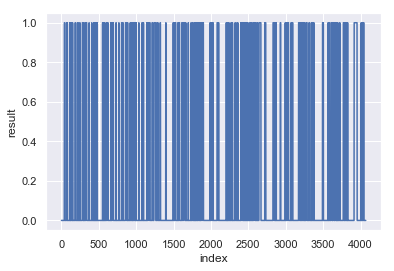

In [89]:
# do some visualization with result column
# we result to be evenly distributed
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = sns.lineplot(x="index", 
                  y="result",
                  data=data)
plt.show()

In [90]:
# Correlation Matrix
corrmat = data.corr()
corrmat.round(2)

,rg,h,l,c1,c2,c3,supp,o_s,p_s,obv1,obv2,obv3,rsi1,rsi2,rsi3,natr,cyc,result,index
rg,1.00,0.01,0.01,0.01,0.01,0.01,0.01,-0.09,-0.21,-0.02,-0.00,0.02,-0.35,-0.25,-0.21,0.03,-0.09,0.08,0.04
h,0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.01,0.07,0.07,0.05,0.00,0.03,-0.01,0.26,0.17,-0.07,-0.04
l,0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.01,0.07,0.07,0.05,0.00,0.03,-0.01,0.26,0.17,-0.07,-0.03
c1,0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.01,0.07,0.07,0.05,0.00,0.03,-0.01,0.26,0.17,-0.07,-0.03
c2,0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.01,0.07,0.07,0.05,0.00,0.03,-0.01,0.26,0.17,-0.07,-0.04
c3,0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.01,0.06,0.07,0.05,0.00,0.03,-0.01,0.26,0.17,-0.07,-0.04
supp,0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.12,-0.01,0.07,0.07,0.05,0.00,0.03,-0.01,0.26,0.17,-0.07,-0.03
o_s,-0.09,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,1.00,0.06,-0.08,-0.07,-0.05,0.00,0.17,0.23,-0.33,-0.21,0.02,0.09
p_s,-0.21,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.06,1.00,0.19,0.21,0.23,0.03,0.11,0.13,0.01,-0.06,0.02,-0.02
obv1,-0.02,0.07,0.07,0.07,0.07,0.06,0.07,-0.08,0.19,1.00,0.98,0.94,0.18,0.25,0.17,0.01,0.02,-0.00,0.02


In [91]:
X = data[['rg', 'h', 'l', 'c1', 'c2', 'c3', 'supp', 'o_s', 'p_s', 'obv1', 'obv2', 'obv3', 'rsi1', 'rsi2', 'rsi3', 'natr', 'cyc']]
y = data['result']

sc = MinMaxScaler()
X = sc.fit_transform(X)

# save sc so we can use it for predictions
scaler_filename = "scaler.save"
joblib.dump(sc, scaler_filename)

#scaler = joblib.load(scaler_filename)
#print(scaler)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

#X_train.head()
y_train.head()

7605    0.0
4194    0.0
555     0.0
3641    0.0
2591    0.0
Name: result, dtype: float64

In [92]:
# build a logistic regression model
# Posted accuracy of .75 - .80

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.7730061349693251


In [93]:
# Build the deep neural net: Posted Accuracy of .9 on train, .85 on test

# Number of neurons in the first layer = number of columns in dataset
# Activation function = ReLU
# 5 Hidden layers for a total of 6 layers in the network
# Last layer activation function = Sigmoid

model = Sequential()
# input layer
model.add(Dense(100, activation='relu', input_dim = 17))
          
# second layer
model.add(Dense(60, activation='relu'))
          
# third layer
model.add(Dense(60, activation='relu'))
          
# fourth layer
model.add(Dense(60, activation='relu'))

# fith layer
model.add(Dense(60, activation='relu'))
          
# output layer
model.add(Dense(1, activation='sigmoid'))

# compile the model using rmsprop opt and mse loss
model.compile(optimizer = 'rmsprop',     
              loss = 'mse',
              metrics = ['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 150, 
                    batch_size = 25)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Train on 2181 samples, validate on 1075 samples
Epoch 1/150
2181/2181 [==============================] - 1s 484us/step - loss: 0.1835 - acc: 0.7597 - val_loss: 0.1773 - val_acc: 0.7805
Epoch 2/150
2181/2181 [==============================] - 0s 123us/step - loss: 0.1795 - acc: 0.7657 - val_loss: 0.1695 - val_acc: 0.7805
Epoch 3/150
2181/2181 [==============================] - 0s 121us/step - loss: 0.1755 - acc: 0.7657 - val_loss: 0.1817 - val_acc: 0.7805
Epoch 4/150
2181/2181 [==============================] - 0s 125us/step - loss: 0.1742 - acc: 0.7657 - val_loss: 0.1640 - val_acc: 0.7805
Epoch 5/150
2181/2181 [==============================] - 0s 123us/step - loss: 0.1691 - acc: 0.7671 - val_loss: 0.1693 - val_acc: 0.7823
Epoch 6/150
2181/2181 [==============================] - 0s 123us/step - loss: 0.1657 - acc: 0.7707 - val_loss: 0.1652 - val_acc: 0.7879
Epoch 7/150
2181/2181 [==============================] - 0s 127us/step - loss: 0.1626 - acc: 0.7694 - val_loss: 0.1586 - val_acc: 

2181/2181 [==============================] - 0s 109us/step - loss: 0.0930 - acc: 0.8780 - val_loss: 0.1423 - val_acc: 0.8195
Epoch 61/150
2181/2181 [==============================] - 0s 108us/step - loss: 0.0946 - acc: 0.8790 - val_loss: 0.1182 - val_acc: 0.8512
Epoch 62/150
2181/2181 [==============================] - 0s 110us/step - loss: 0.0923 - acc: 0.8803 - val_loss: 0.1539 - val_acc: 0.8028
Epoch 63/150
2181/2181 [==============================] - 0s 109us/step - loss: 0.0930 - acc: 0.8799 - val_loss: 0.1246 - val_acc: 0.8474
Epoch 64/150
2181/2181 [==============================] - 0s 117us/step - loss: 0.0916 - acc: 0.8826 - val_loss: 0.1595 - val_acc: 0.7795
Epoch 65/150
2181/2181 [==============================] - 0s 109us/step - loss: 0.0919 - acc: 0.8854 - val_loss: 0.1302 - val_acc: 0.8335
Epoch 66/150
2181/2181 [==============================] - 0s 116us/step - loss: 0.0884 - acc: 0.8863 - val_loss: 0.1267 - val_acc: 0.8428
Epoch 67/150
2181/2181 [=======================

2181/2181 [==============================] - 0s 116us/step - loss: 0.0585 - acc: 0.9266 - val_loss: 0.1144 - val_acc: 0.8642
Epoch 120/150
2181/2181 [==============================] - 0s 109us/step - loss: 0.0599 - acc: 0.9298 - val_loss: 0.1232 - val_acc: 0.8502
Epoch 121/150
2181/2181 [==============================] - 0s 110us/step - loss: 0.0612 - acc: 0.9285 - val_loss: 0.1210 - val_acc: 0.8558
Epoch 122/150
2181/2181 [==============================] - 0s 115us/step - loss: 0.0560 - acc: 0.9321 - val_loss: 0.1211 - val_acc: 0.8614
Epoch 123/150
2181/2181 [==============================] - 0s 107us/step - loss: 0.0587 - acc: 0.9257 - val_loss: 0.1378 - val_acc: 0.8307
Epoch 124/150
2181/2181 [==============================] - 0s 115us/step - loss: 0.0579 - acc: 0.9276 - val_loss: 0.1288 - val_acc: 0.8344
Epoch 125/150
2181/2181 [==============================] - 0s 109us/step - loss: 0.0576 - acc: 0.9317 - val_loss: 0.1167 - val_acc: 0.8605
Epoch 126/150
2181/2181 [================

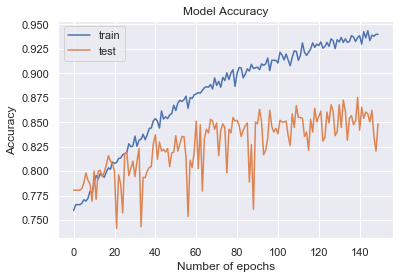

In [94]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

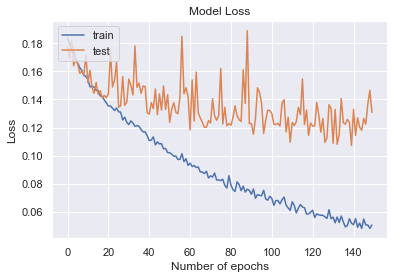

In [95]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               1800      
_________________________________________________________________
dense_26 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_27 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_28 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_29 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 61        
Total params: 18,901
Trainable params: 18,901
Non-trainable params: 0
_________________________________________________________________


In [97]:
predictions = model.predict(X_test)

In [98]:
# save the model for later use

from keras.models import load_model
model.save('DNN_Breakout')  # creates a HDF5 file
del model  # deletes the existing model

# load model to make sure that it was correctly saved
model = load_model('DNN_Breakout')

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test set accuracy:', test_acc)

815/815 [==============================] - 0s 212us/step
Test set accuracy: 0.8638036810547296
